# Производительность воркера на GPU с **whisper** по сравнению с CPU-воркерами на Vosk

In [1]:
import warnings
import pandas as pd
import plotly.graph_objs as go
import pymssql

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
def ms_sql_con():
    sql_name = 'voice_ai'
    sql_server = '10.2.4.124'
    sql_login = 'ICECORP\\1c_sql'

    with open('sql.pass','r') as file:
        sql_pass = file.read().replace('\n', '')
        file.close()

    return pymssql.connect(
            server = sql_server,
            user = sql_login,
            password = sql_pass,
            database = sql_name,
            tds_version=r'7.0'
    )

In [3]:
def read_sql(query):
    return pd.read_sql_query(query, con=ms_sql_con(), parse_dates=None)

In [4]:
def perfomance_by_cpu(start_date, end_date):
    query = "select file_name, cpu, step, time, duration"
    query += " from perf_log "
    query += " where event_date > '"+start_date+"'"
    query += " and event_date < '"+end_date+"'"
    query += " and step = 2;"

    df = read_sql(query)
    df['td'] = df.time/df.duration

    if len(df):
        df.groupby('cpu').count().plot(
            y = ['file_name'], 
            kind="bar",
            width=.8,
            figsize=(20, 6),
            ylabel='Количество файлов', 
            title='Транскрибация аудиофайлов по воркерам',
            legend=False
        )

        sum_dur = df.duration.sum()

        gpu_min = df['duration'].sum() / 60
        gpu_h = gpu_min / 60
        df.drop(['file_name', 'time', 'duration'], axis=1, inplace = True)

        df.groupby('cpu').median().plot(
            y = ['td'], 
            kind="bar",
            width=.8,
            figsize=(20, 6),
            ylabel='Производительность', 
            title='Медианная производительность транскрибации',
            legend=False
        )

    print(f'Общее количество распознанных аудиофайлов: {len(df)}')
    print(f'Суммарная длительность записей, распознанных Whisper: {round(gpu_min)} мин ({round(gpu_h)} ч)')
    
    # Возвращаем длительность всех файлов в сек,
    # а также производительности 0 и 1 воркеров
    return sum_dur, df.groupby('cpu').median().td[0], df.groupby('cpu').median().td[1]

Общее количество распознанных аудиофайлов: 28250
Суммарная длительность записей, распознанных Whisper: 43292 мин (722 ч)


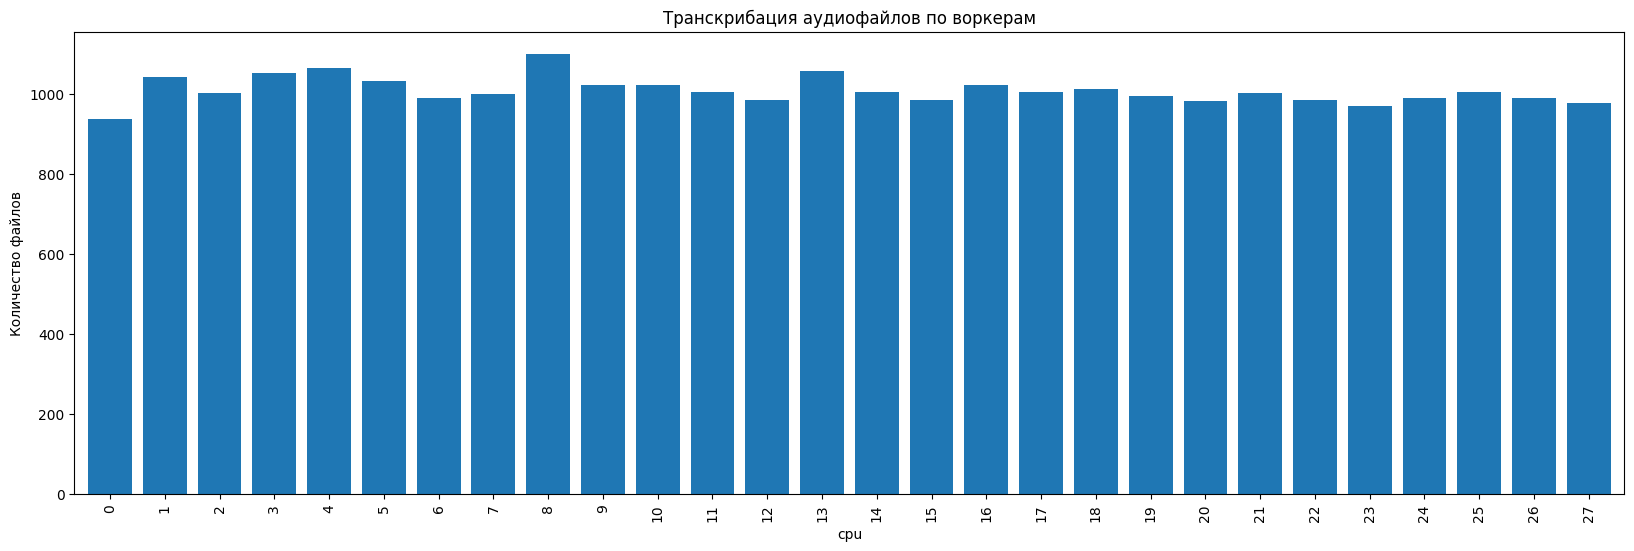

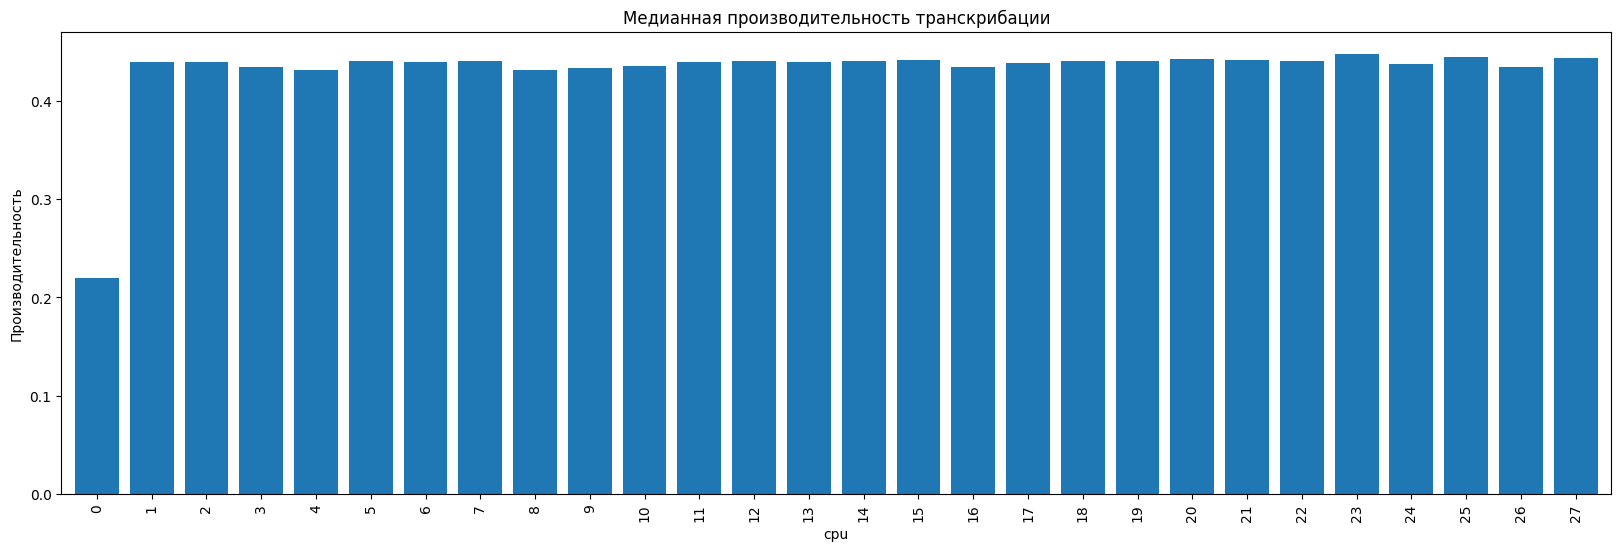

In [5]:
start_date = '2024-02-06 14:50:00'
end_date = '2024-02-08 13:50:00'
sum_dur, cpu0_perf, cpu1_perf = perfomance_by_cpu(start_date, end_date)

In [6]:
query_whisper = '''
SELECT CAST(transcribation_date AS DATE),
       conf,
       linkedid,
       audio_file_name,
       model
FROM transcribations
WHERE CAST(transcribation_date AS DATE) BETWEEN '2024-02-05' AND '2024-02-09'
AND model = 1;
'''

query_vosk = '''
SELECT CAST(transcribation_date AS DATE),
       conf,
       linkedid,
       audio_file_name,
       model
FROM transcribations
WHERE CAST(transcribation_date AS DATE) BETWEEN '2024-02-05' AND '2024-02-09'
AND model = 0;
'''

In [7]:
df_query_whisper = read_sql(query_whisper).drop_duplicates(
    subset=['linkedid', 'audio_file_name']
)
df_query_vosk = read_sql(query_vosk).drop_duplicates(
    subset=['linkedid', 'audio_file_name']
)

print(
    f'Средняя уверенность Whisper в распознанном тексте: {round(df_query_whisper.conf.mean(), 3)}'
)
print(
    f'Средняя уверенность Vosk в распознанном тексте: {round(df_query_vosk.conf.mean(), 3)}'
)

Средняя уверенность Whisper в распознанном тексте: 0.78
Средняя уверенность Vosk в распознанном тексте: 0.695


In [8]:
idle0_query = '''
SELECT event_date,
       step,
       cpu,
       duration,
       time
FROM perf_log
WHERE event_date BETWEEN '2024-02-06 14:50:00' AND '2024-02-08 13:50:00'
    AND cpu = 0
    AND step = 2
ORDER BY event_date;
'''

idle1_query = '''
SELECT event_date,
       step,
       cpu,
       duration,
       time
FROM perf_log
WHERE event_date BETWEEN '2024-02-06 14:50:00' AND '2024-02-08 13:50:00'
    AND cpu = 1
    AND step = 2
ORDER BY event_date;
'''

In [9]:
df_idle0_query = read_sql(idle0_query)

df_idle0_query['event_date'] = pd.to_datetime(df_idle0_query['event_date']) 
df_idle0_query['end_time'] = df_idle0_query['event_date'] + pd.to_timedelta(
    df_idle0_query['time'],
    unit='s'
) 
df_idle0_query['next_start'] = df_idle0_query['event_date'].shift(-1) 
df_idle0_query['idle_time'] = (
    df_idle0_query['event_date'].shift(-1) - df_idle0_query['end_time']
    ).fillna(pd.Timedelta(seconds=0))

fig_idle0_query = go.Figure()

for index, row in df_idle0_query.iterrows():
    if row['idle_time'] > pd.Timedelta(0):

        fig_idle0_query.add_trace(go.Scatter(
            x=[row['end_time'], row['end_time'] + row['idle_time']],
            y=[0, 0],
            mode='lines',
            line=dict(color='red', width=3)
        ))

    fig_idle0_query.add_trace(go.Scatter(
        x=[row['event_date'], row['end_time']],
        y=[row['time'], row['time']],
        mode='lines',
        line=dict(color='blue', width=3)
    ))

fig_idle0_query.update_layout(
    title=dict(
        text='Длительность распознаваний и простоев Whisper воркера',
        x=.5
        ),
    width=1800,
    height=500,
    xaxis_title='Время',
    yaxis_title='Длительность, сек',
    showlegend = False
)
None

In [10]:
df_idle1_query = read_sql(idle1_query)

df_idle1_query['event_date'] = pd.to_datetime(df_idle1_query['event_date']) 
df_idle1_query['end_time'] = df_idle1_query['event_date'] + pd.to_timedelta(
    df_idle1_query['time'],
    unit='s'
) 
df_idle1_query['next_start'] = df_idle1_query['event_date'].shift(-1) 
df_idle1_query['idle_time'] = (
    df_idle1_query['event_date'].shift(-1) - df_idle1_query['end_time']
    ).fillna(pd.Timedelta(seconds=0))

fig_idle1_query = go.Figure()

for index, row in df_idle1_query.iterrows():
    if row['idle_time'] > pd.Timedelta(0):

        fig_idle1_query.add_trace(go.Scatter(
            x=[row['end_time'], row['end_time'] + row['idle_time']],
            y=[0, 0],
            mode='lines',
            line=dict(color='red', width=3)
        ))

    fig_idle1_query.add_trace(go.Scatter(
        x=[row['event_date'], row['end_time']],
        y=[row['time'], row['time']],
        mode='lines',
        line=dict(color='blue', width=3)
    ))

fig_idle1_query.update_layout(
    title=dict(
        text='Длительность распознаваний и простоев Vosk воркера',
        x=.5
        ),
    width=1800,
    height=500,
    xaxis_title='Время',
    yaxis_title='Длительность, сек',
    showlegend = False
)
None

In [11]:
fig_idle0_query.show()
fig_idle1_query.show()

In [21]:
# Считаем общее время простоя воркеров
idle_whisper = df_idle0_query[df_idle0_query["idle_time"]>pd.Timedelta(0)].idle_time.sum().total_seconds()
idle_vosk = df_idle1_query[df_idle1_query["idle_time"]>pd.Timedelta(0)].idle_time.sum().total_seconds()

# Считаем долю простоя за вычетом периодов отстутствия задач / сбоев в работе
percent_whisper = (idle_whisper - 91800) / 72000
percent_vosk = (idle_vosk - 69000) / 94800

print(
    f'Доля времени простоя Whisper от всего времени запуска: {percent_whisper:.1%}'
)
print(
    f'Доля времени простоя Vosk от всего времени запуска: {percent_vosk:.1%}'
)

Доля времени простоя Whisper от всего времени запуска: 82.8%
Доля времени простоя Vosk от всего времени запуска: 71.7%


### Посчитаем, какой объём дополнительной работы могли бы взять на себя воркеры, чтобы понять их актуальное необходимое количество.

In [18]:
print(f'Один Whisper GPU воркер мог бы взять на себя {(idle_whisper / cpu0_perf / percent_whisper / sum_dur):.1%} всей работы')

Один Whisper GPU воркер мог бы взять на себя 32.1% всей работы


In [19]:
print(f'Один Vosk CPU воркер мог бы взять на себя {(idle_vosk / cpu1_perf / percent_vosk / sum_dur):.1%} всей работы')

Один Vosk CPU воркер мог бы взять на себя 16.7% всей работы


In [16]:
print(f'Сейчас каждый воркер берёт на себя в среднем {(1/28):.1%} всей работы')

Сейчас каждый воркер берёт на себя в среднем 3.6% всей работы


### Следовательно, при актуальном объёме аудиозаписей на распознавание возможно обойтись 16.7% * **5** CPU воркерами (83.5% всей работы)
### и 32% * **1** GPU воркером.